In [1]:
'''This script demonstrates ICM on image data

 #Reference
 Curiosity-driven Exploration by Self-supervised Prediction
 https://arxiv.org/abs/1705.05363
'''
import warnings
import sys, os
from glob import glob
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.mlab as mlab
import matplotlib.image as mpimg
#plt.rcParams["figure.figsize"] = [20,20]
from scipy.stats import norm
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer, Dropout
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
import keras
from skimage.transform import resize
from PIL import Image
import csv
from sklearn import preprocessing

data_dir = 'img_0'
num_data = 1710

Using TensorFlow backend.


In [2]:
# Read the poses and observations
with open(data_dir + "/lookup_pitch_yaw.csv", "r") as f:
    reader = csv.reader(f, delimiter=',')
    pose_pitch_yaw = np.asarray([[float(x[0]), float(x[1])] for x in list(reader)[1:]])
    f.close()

def get_iterator(batch_size):
    from keras.preprocessing.image import ImageDataGenerator
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=False,
        width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.0)  # randomly shift images vertically (fraction of total height))

    train_generator = train_datagen.flow_from_directory(data_dir, interpolation='nearest',
            color_mode='rgb', shuffle=False, seed=None,
            target_size=(60, 80),
            batch_size=batch_size,
            #save_to_dir='img_0_augmented',
            class_mode=None)
    return train_generator
X_train = get_iterator(num_data).next()

Found 1710 images belonging to 1 classes.


Found 1710 images belonging to 1 classes.
(60, 80, 3)


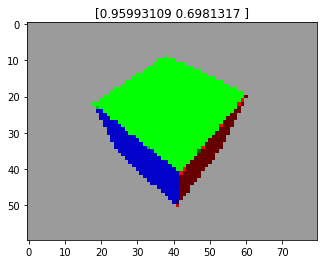

In [3]:
# Show some scaled image
generator = get_iterator(1)
idx = 1000
for _ in range(idx+1):
    x = generator.next()
print(x[0].shape)
plt.imshow(x[0])
plt.title(str(pose_pitch_yaw[idx]))
plt.show()

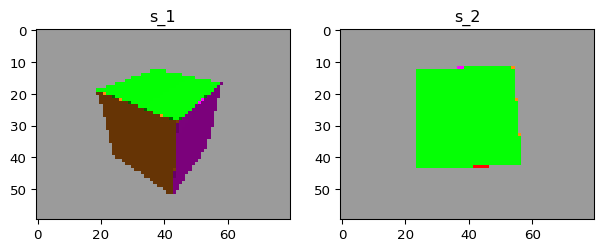

Pose s_1:  [0.61086524 3.76991118]
Pose s_2:  [1.3962634  1.53588974]
Action s_1 -> s_2:  [0.85355339 0.10599462 0.85355339 0.19216926]


In [11]:
# Create the action/perception tuples
num_tuples = int(10 * num_data)

# Creates actions for given start and end angles
def angle_diff(s, e):
    return (1 + np.concatenate([np.sin(e - s), np.cos(e - s)], axis=1)) / 2.0
    #return np.concatenate([e - s, e - s], axis=1)

# example for angle_diff
#s = np.asarray([[0.0, 0.0], [0.0, 0.0], [np.pi/2, 0.0]])
#e = np.asarray([[np.pi/2, -np.pi/2], [np.pi/2, -np.pi/2], [np.pi/2, -np.pi/2]])
#print(angle_diff(s, e))

np.random.seed(0)
s1_idx = np.random.randint(0, high=num_data, size=num_tuples)
s2_idx = np.random.randint(0, high=num_data, size=num_tuples)

X_train_actions = angle_diff(pose_pitch_yaw[s1_idx], pose_pitch_yaw[s2_idx])
X_train_s1 = X_train[s1_idx]
X_train_s2 = X_train[s2_idx]

# Show a tuple
f, ax = plt.subplots(1,2,figsize=(7.5,7.5), dpi=96)
ax[0].imshow(X_train_s1[0])
ax[1].imshow(X_train_s2[0])
ax[0].set_title('s_1')
ax[1].set_title('s_2')
plt.show()
print("Pose s_1: ", pose_pitch_yaw[s1_idx[0]])
print("Pose s_2: ", pose_pitch_yaw[s2_idx[0]])
print("Action s_1 -> s_2: ", X_train_actions[0])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feat_inp_s2 (InputLayer)        (None, 14400)        0                                            
__________________________________________________________________________________________________
feat_inp_s1 (InputLayer)        (None, 14400)        0                                            
__________________________________________________________________________________________________
feat_model_s2 (Model)           (None, 2)            461402      feat_inp_s2[0][0]                
                                                                 feat_inp_s2[0][0]                
_____________________

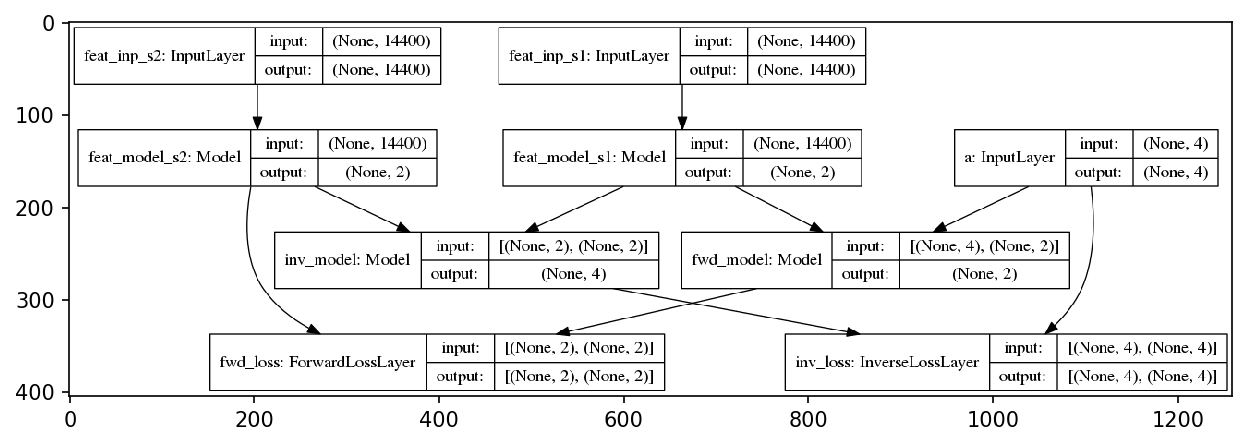

In [5]:
# input image dimensions and config
batch_size = 128
epochs = 100
image_rows_cols_chns = (60, 80, 3)
original_dim = np.prod(image_rows_cols_chns)
action_dim = 4
feat_dim = 2
intermediate_dim = 32
intermediate_dim_2 = int(intermediate_dim / 2.)
beta = 0.1 # in the paper beta := 0.2

# Feature extractor
feat_trainable = True
feat_inp_s1 = Input(shape=(original_dim,), name="feat_inp_s1")
feat_inp_s2 = Input(shape=(original_dim,), name="feat_inp_s2")
feat_h1  = Dense(intermediate_dim, activation='elu', name="feat_h1", trainable=feat_trainable)
feat_d1  = Dropout(rate=0.4, name="feat_d1")
feat_h2  = Dense(intermediate_dim_2, activation='elu', name="feat_h2", trainable=feat_trainable)
feat_d2  = Dropout(rate=0.4, name="feat_d2")
feat_out  = Dense(feat_dim, name="feat_out", trainable=feat_trainable)
feat_out_bn = keras.layers.BatchNormalization()

# w/o dropout
#feat_model_s1 = Model(feat_inp_s1, feat_out(feat_h2(feat_h1(feat_inp_s1))), name="feat_model_s1")
#feat_model_s2 = Model(feat_inp_s2, feat_out(feat_h2(feat_h1(feat_inp_s2))), name="feat_model_s2")
# w/ dropout
#feat_model_s1 = Model(feat_inp_s1, feat_out(feat_d1(feat_h2(feat_d1(feat_h1(feat_inp_s1))))), name="feat_model_s1")
#feat_model_s2 = Model(feat_inp_s2, feat_out(feat_d1(feat_h2(feat_d1(feat_h1(feat_inp_s2))))), name="feat_model_s2")
# w/ dropout and batchnorm
feat_model_s1 = Model(feat_inp_s1, feat_out_bn(feat_out(feat_d1(feat_h2(feat_d1(feat_h1(feat_inp_s1)))))), name="feat_model_s1")
feat_model_s2 = Model(feat_inp_s2, feat_out_bn(feat_out(feat_d1(feat_h2(feat_d1(feat_h1(feat_inp_s2)))))), name="feat_model_s2")

# Inverse model (action predictor)
fwd_feat_inp_s1 = Input(shape=(feat_dim,), name="fwd_feat_inp_s1")
fwd_feat_inp_s2 = Input(shape=(feat_dim,), name="fwd_feat_inp_s2")
inv_concat = keras.layers.Concatenate(axis=-1, name="inv_concat")
inv_h1  = Dense(intermediate_dim_2, activation='elu', name="inv_h1")
inv_d1  = Dropout(rate=0.4, name="inv_d1")
inv_h2  = Dense(intermediate_dim_2, activation='elu', name="inv_h2")
inv_d2  = Dropout(rate=0.4, name="inv_d2")
inv_out = Dense(action_dim, name="inv_out")

# w/o dropout
#inv_model = Model([fwd_feat_inp_s1, fwd_feat_inp_s2], inv_out(inv_h2(inv_h1(inv_concat([fwd_feat_inp_s1, fwd_feat_inp_s2])))), name="inv_model")
# w/ dropout
inv_model = Model([fwd_feat_inp_s1, fwd_feat_inp_s2],
                  inv_out(inv_d2(inv_h2(inv_d1(inv_h1(inv_concat([fwd_feat_inp_s1, fwd_feat_inp_s2])))))), name="inv_model")

# Forward model (feature predictor)
fwd_trainable = True
fwd_inp = Input(shape=(action_dim,), name="a")
fwd_concat = keras.layers.Concatenate(axis=-1, name="fwd_concat")
fwd_h1  = Dense(intermediate_dim_2, activation='elu', name="fwd_h1", trainable=fwd_trainable)
fwd_d1  = Dropout(rate=0.4, name="fwd_d1")
fwd_h2  = Dense(intermediate_dim_2, activation='elu', name="fwd_h2", trainable=fwd_trainable)
fwd_d2  = Dropout(rate=0.4, name="fwd_d2")
fwd_out = Dense(feat_dim, name="fwd_out", trainable=fwd_trainable)

# w/o dropout
fwd_model = Model([fwd_inp, fwd_feat_inp_s1], fwd_out(fwd_h2(fwd_h1(fwd_concat([fwd_inp, fwd_feat_inp_s1])))), name="fwd_model")
# w/ dropout
#fwd_model = Model([fwd_inp, fwd_feat_inp_s1], fwd_out(fwd_d2(fwd_h2(fwd_d1(fwd_h1(fwd_concat([fwd_inp, fwd_feat_inp_s1])))))), name="fwd_model")

# Define the losses

# loss layer
class InverseLossLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(InverseLossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        fwd_inp = inputs[0]
        inv_out = inputs[1]
        loss = (1. - beta) * K.mean(keras.losses.mse(fwd_inp, inv_out))
        self.add_loss(loss, inputs=inputs)
        return loss
class ForwardLossLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(ForwardLossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        feat_out_s2 = inputs[0]
        fwd_out = inputs[1]
        loss = beta * 0.5 * K.mean(keras.losses.mse(feat_out_s2, fwd_out))
        self.add_loss(loss, inputs=inputs)
        return loss

# Build the complete model
fwd_loss = ForwardLossLayer(name="fwd_loss")([feat_model_s2(feat_inp_s2), fwd_model([fwd_inp, feat_model_s1(feat_inp_s1)])])
inv_loss = InverseLossLayer(name="inv_loss")([fwd_inp, inv_model([feat_model_s1(feat_inp_s1), feat_model_s2(feat_inp_s2)])])
icm_model = Model([feat_inp_s1, feat_inp_s2, fwd_inp], [fwd_loss, inv_loss], name="icm_model")

# Create a history class which stores the ouputs of the loss layer after every epoch
class History(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.history = {}
        self.epoch = []

    def on_epoch_end(self, epoch, logs={}):
        self.epoch.append(epoch)
        # Get the output layer names (we only have loss layers as output)
        output_layer_names = [output_layer.name for output_layer in self.model.output]
        # Get the mean error over all batches in this epoch
        num_eval = num_data
        output_layer_values = np.mean(self.model.predict([X_train_s1_flatten[:num_eval], X_train_s2_flatten[:num_eval], X_train_actions[:num_eval]]), axis = 1)
        #output_layer_values = self.model.predict([X_train_s1_flatten, X_train_s2_flatten, X_train_actions], batch_size = X_train_s1_flatten.shape[0])
        # Store it to the history
        for k, v in zip(output_layer_names, output_layer_values):
            self.history.setdefault(k, []).append(v)
        return

# Compile and show it
icm_model.compile(keras.optimizers.Adam(lr=0.0001), loss=None)
icm_model.summary()
plot_model(icm_model, to_file='/tmp/ICM.png', show_shapes=True, show_layer_names=True)
f, ax = plt.subplots(1,1,figsize=(10, 10), dpi=150)
ax.imshow(mpimg.imread('/tmp/ICM.png'))
plt.show()

In [6]:
# Train
output_history = History()
X_train_s1_flatten = X_train_s1.reshape((X_train_s1.shape[0], np.prod(X_train_s1.shape[1:])))
X_train_s2_flatten = X_train_s2.reshape((X_train_s2.shape[0], np.prod(X_train_s2.shape[1:])))
h = icm_model.fit([X_train_s1_flatten,
               X_train_s2_flatten,
               X_train_actions],
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        verbose = 0,
        callbacks=[output_history])
#print(h.history)
#print(output_history.history)

Instructions for updating:
Use tf.cast instead.


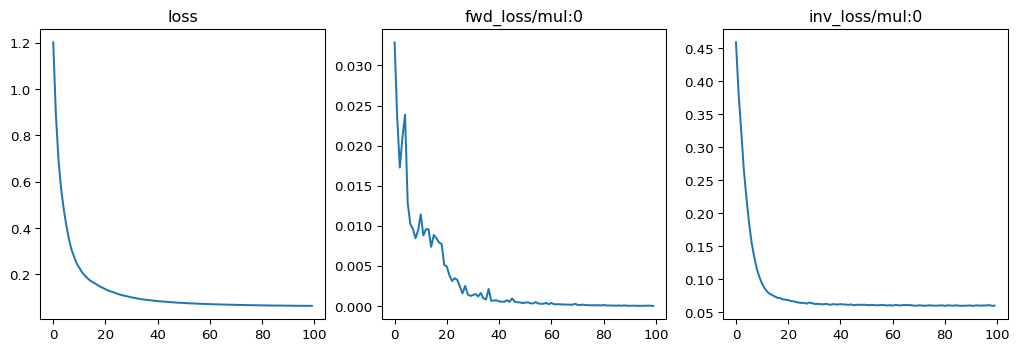

In [7]:
plt_key = [list(h.history.keys())[0], list(output_history.history.keys())[0], list(output_history.history.keys())[1]]
plt_val = [h.history[plt_key[0]], output_history.history[plt_key[1]], output_history.history[plt_key[2]]]
f, ax = plt.subplots(1,3, figsize=(13,4), dpi=96)
for idx in range(3):
    ax[idx].plot(plt_val[idx])
    ax[idx].set_title(plt_key[idx])
plt.show()

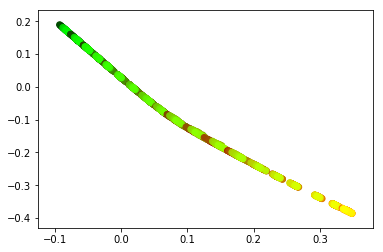

In [8]:
# Check the output distribution of the feature extractor
X_train_flatten = X_train.reshape((X_train.shape[0], np.prod(X_train.shape[1:])))
X_train_feat = feat_model_s1.predict(X_train_flatten)
c = np.concatenate(((pose_pitch_yaw - np.min(pose_pitch_yaw, axis=0)) / np.max(pose_pitch_yaw, axis=0), np.zeros((num_data,1))), axis=1)
plt.scatter(X_train_feat[:,0], X_train_feat[:,1], c=c)
plt.show()

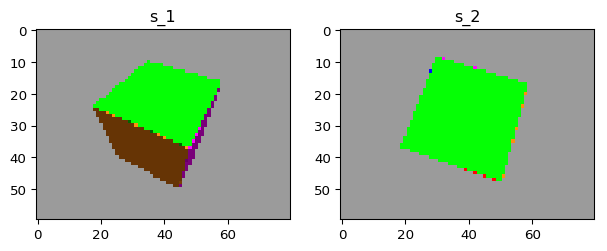

True: [0.75       0.00759612 0.9330127  0.41317591]
 vs. 
Pred: [[0.6746417  0.49293056 0.8937499  0.50078464]]

Diff: 0.06261131059866666


In [9]:
# Check the inverse model (i.e. predicting the action from consecutive observations)
idx = 3
pred_action = inv_model.predict([feat_model_s1.predict(X_train_s1_flatten[[idx]]),
                                 feat_model_s1.predict(X_train_s2_flatten[[idx]])])
f, ax = plt.subplots(1,2,figsize=(7.5,7.5), dpi=96)
ax[0].imshow(X_train_s1[idx])
ax[1].imshow(X_train_s2[idx])
ax[0].set_title('s_1')
ax[1].set_title('s_2')
plt.show()
print("True: " + str(X_train_actions[idx]) + "\n vs. \nPred: " + str(pred_action))
print("\nDiff: " + str(np.mean((X_train_actions[idx] - pred_action)**2)))

In [10]:
# Check the forward model (i.e. predicting the next obs. from current action and obs.)
idx = 2
pred_obs = fwd_model.predict([X_train_actions[[idx]],
                              feat_model_s1.predict(X_train_s1_flatten[[idx]])])
pred_obs_gt = feat_model_s1.predict(X_train_s2_flatten[[idx]])
print("True: " + str(pred_obs_gt) + "\n vs. \nPred: " + str(pred_obs))
print("\nReward: " + str(np.mean((pred_obs_gt - pred_obs)**2)))

True: [[ 0.26546863 -0.30335593]]
 vs. 
Pred: [[ 0.21825394 -0.24688743]]

Reward: 0.0027089592
